In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tapm import utils

# Parameters of the system and basic function definitions

In [3]:
# Parameters
args, y0 = utils.read_params(filename="model_params.txt")


def calculate_m(
    H, min_exp=args["min_exp"], max_exp=args["max_exp"], tau_exp=args["tau_exp"]
):
    return min_exp + (max_exp - min_exp) * (1 - np.exp(-H / tau_exp))


def calculate_lambda_a(args, lambda_P, m, P, H):
    return (lambda_P* P) + (
        args["c"] * (1 - m) * args["beta_HIV"] * H * (1 - P)
    )


# Alpha
def calculate_alpha(P, m, beta_STI=args["beta_STI"]):
    return beta_STI * (1 - m * (1 - P))


def calculate_a(args):
    return args["lambda_s"] + args["mu"]


def calculate_b(args, lambda_a):
    return args["gamma_STI"] + lambda_a + args["mu"]


def calculate_R_0(args, b, alpha, a):
    return (
        (
            ((args["asymptomatic"] * alpha * a / b)
            + (1 - args["asymptomatic"]) * alpha
        )
    ) / a)

def calculate_Omega(args, b, a):
    return (b/a)*(1 - args["asymptomatic"]) / args["asymptomatic"]

def calculate_S(args, omega, b, alpha):
    return b/(args["asymptomatic"]*alpha*(1+omega))


def calculate_I_STI_a(args, lambda_P, H, P):
    # Calculate a, b, and R_0
    m = calculate_m(H)
    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    alpha = calculate_alpha(P, m)
    a = calculate_a(args)
    b = calculate_b(args, lambda_a)
    R_0 = calculate_R_0(args, b, alpha, a)

    # Calculate I_STI^a,*
    numerator = (args["mu"] + args["gammaT_STI"]) * (1 / R_0 - 1)
    denominator = (
        -b / args["asymptomatic"]
        + args["gamma_STI"]
        - args["gammaT_STI"]
        * (1 + (b / a) * (1 - args["asymptomatic"]) / args["asymptomatic"])
    )

    I_STI_a_star = numerator / denominator

    return I_STI_a_star

def calculate_I_JOHANNES(args, lambda_P, H, P):
    # Calculate a, b, and R_0
    m = calculate_m(H)
    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    alpha = calculate_alpha(P, m)
    a = calculate_a(args)
    b = calculate_b(args, lambda_a)
    omega = calculate_Omega(args, b, a)
    S=calculate_S(args, omega, b, alpha)

    # Calculate I_STI^a,*
    numerator = (args["mu"] + args["gammaT_STI"]) - (args["gammaT_STI"]-args["mu"])*S
    denominator = (
        alpha*(S+omega)-args["gamma_STI"]+args["gammaT_STI"]*(1+omega)
    )

    I_STI_a_star = numerator / denominator

    return I_STI_a_star

def calculate_I_MATHEMATICA(args, lambda_P, H, P):
    # Calculate a, b, and R_0
    m = calculate_m(H)
    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    alpha = calculate_alpha(P, m)
    a = calculate_a(args)
    b = calculate_b(args, lambda_a)
    varphi=b+a*args["asymptomatic"]-b*args["asymptomatic"]
    Ro=calculate_Ro(args, lambda_P, H, P)
    # Calculate I_STI^a,*
    numerator = (args["mu"] + args["gammaT_STI"])*a*args["asymptomatic"]*(1-1/Ro)
    denominator = (
        a*b-a*args["gamma_STI"]*args["asymptomatic"]+args["gammaT_STI"]*varphi
    )

    I_STI_a_star = numerator / denominator

    return I_STI_a_star

def calculate_S_MATHEMATICA(args, lambda_P, H, P):
    m = calculate_m(H)
    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    alpha = calculate_alpha(P, m)
    a = calculate_a(args)
    b = calculate_b(args, lambda_a)
    varphi=b+a*args["asymptomatic"]-b*args["asymptomatic"]

    S_math=a*b/(alpha*(varphi))

    return S_math

def calculate_Ro(args, lambda_P, H, P):
    m = calculate_m(H)
    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    S=calculate_S_MATHEMATICA(args, lambda_P, H, P)

    Ro=1/S

    return Ro

def SirsComparisona(args, lambda_P, H, P):
    m = calculate_m(H)
    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    
    return args["gammaT_STI"]*(args["asymptomatic"]*args["beta_STI"]*(1-m)-(args["gamma_STI"]+lambda_a))/((args["asymptomatic"]*args["beta_STI"]*(1-m))*(args["gamma_STI"]+lambda_a+args["gammaT_STI"]))

def calculateI_Symtomatic_Math(args, lambda_P, H, P):
    m = calculate_m(H)
    lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
    a = calculate_a(args)
    b = calculate_b(args, lambda_a)
    asym=calculate_I_MATHEMATICA(args, lambda_P, H, P)
    return asym*(b/a)*(1-args["asymptomatic"])/args["asymptomatic"]

# SIRS Comparison with _our parameters_

0.0 0.680508453900017


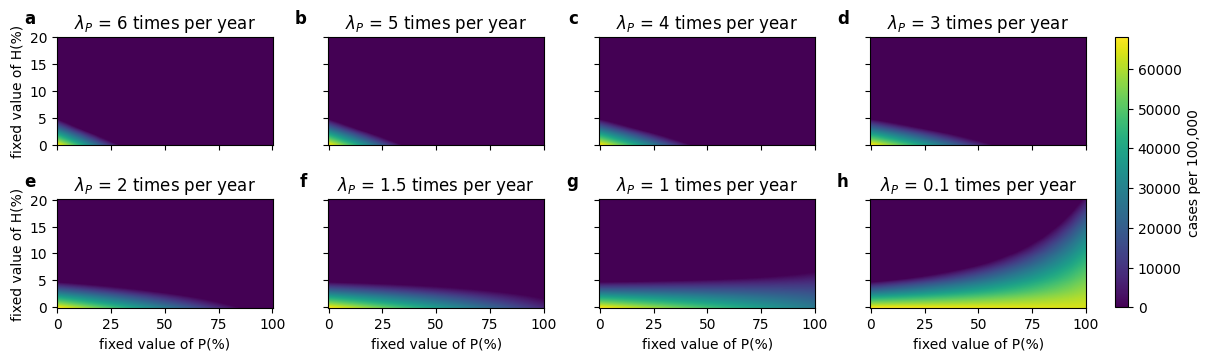

In [33]:

# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
    "0.1 times per year",
]


# Store the results for each lambda_P
results = {}

# Calculate SirsComparison for each combination of lambda_P, H, P
for lambda_P in lambda_P_values:
    result = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            if SirsComparisona(args, lambda_P, H, P)>0:
                result[i, j] = SirsComparisona(args, lambda_P, H, P)
    results[lambda_P] = result  # Store the raw results

# Determine the global vmin and vmax
all_infections = np.concatenate([results[lambda_P].flatten() for lambda_P in lambda_P_values])
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)
print(global_vmin, global_vmax)

# Plotting
num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}

fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax, cmap="viridis")
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )

    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)

cbar.ax.set_ylabel("cases per 100,000")
plt.show()


# Analytical equations heatmap for $\lambda_P$

Min I 0.0 Max I 0.6777144942229621
I [[0.67771449 0.66510024 0.65251317 ... 0.         0.         0.        ]
 [0.6479429  0.63541829 0.62292156 ... 0.         0.         0.        ]
 [0.61829341 0.6058585  0.5934522  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Min I 0.0 Max I 0.6777144942229621
I [[0.67771449 0.66720072 0.65670584 ... 0.         0.         0.        ]
 [0.6479429  0.63752882 0.6271342  ... 0.         0.         0.        ]
 [0.61829341 0.60797934 0.5976853  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Min I 0.0 Max I 0.6777144942229621
I [

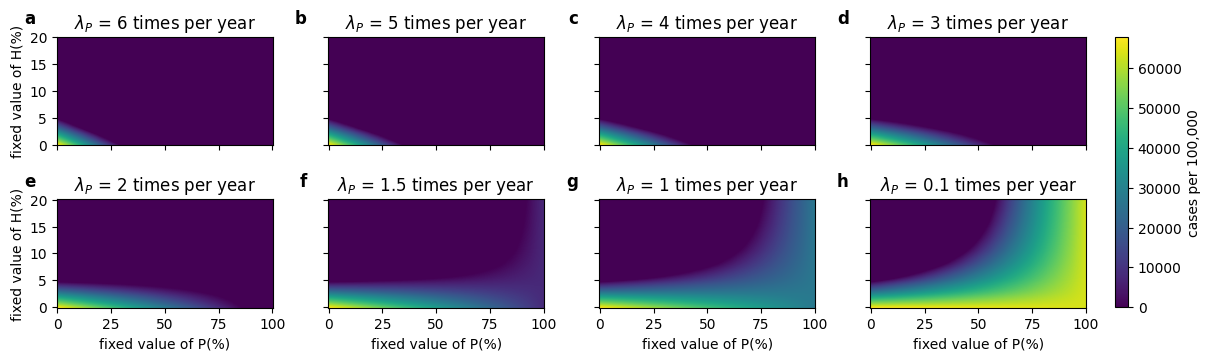

In [25]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
    "0.1 times per year",
]

# Calculate log(I_star_STI) values for each combination of H, P, and lambda_P
results = {}
for lambda_P in lambda_P_values:
    I_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = calculate_m(H)
            lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
            alpha = calculate_alpha(P, m)
            a = calculate_a(args)
            b = calculate_b(args, lambda_a)
            if calculate_R_0(args, b, alpha, a) > 1:
                I_values[i, j] = calculate_I_STI_a(args, lambda_P, H, P)
                # print(lambda_P, H, P, I_star_STI(H, P, lambda_P))
                # print(I_star_STI(H, P, lambda_P))
    results[lambda_P] = I_values
    print("Min I", np.min(I_values), "Max I", np.max(I_values))
    print("I", I_values)
    # print(I_values[0, 0])

# Determine the global vmin and vmax for log(I_star_STI)
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)

global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)
print(global_vmin, global_vmax)

# Plotting
num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}

fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower")
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )

    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):

    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)


cbar.ax.set_ylabel("cases per 100,000")


plt.show()

# Johannes derivation

Min I 0.0 Max I 0.6778485258665633
I [[0.67784853 0.66524438 0.65266768 ... 0.         0.         0.        ]
 [0.64810411 0.63559015 0.6231043  ... 0.         0.         0.        ]
 [0.61848306 0.60605927 0.59366426 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Min I 0.0 Max I 0.6778485258665633
I [[0.67784853 0.66734317 0.65685687 ... 0.         0.         0.        ]
 [0.64810411 0.63769887 0.62731323 ... 0.         0.         0.        ]
 [0.61848306 0.60817819 0.59789348 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Min I 0.0 Max I 0.6778485258665633
I [

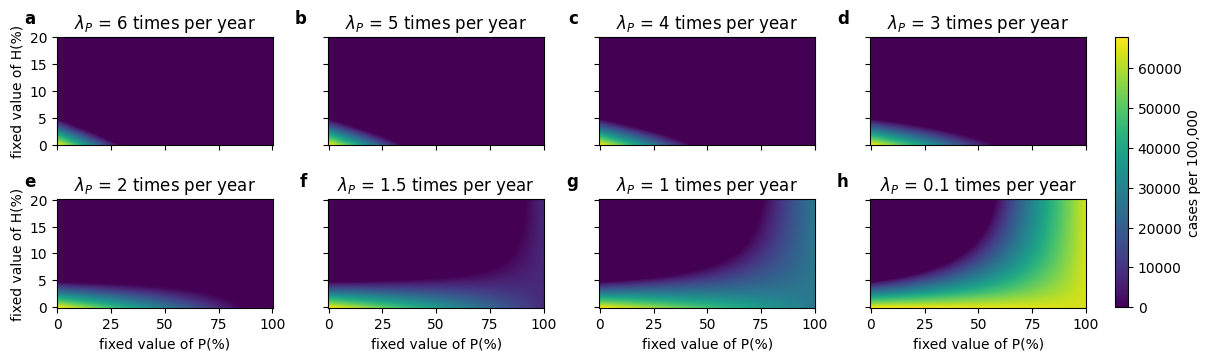

In [28]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
    "0.1 times per year",
]

# Calculate I_star_STI) values for each combination of H, P, and lambda_P
results = {}
for lambda_P in lambda_P_values:
    I_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = calculate_m(H)
            lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
            alpha = calculate_alpha(P, m)
            a = calculate_a(args)
            b = calculate_b(args, lambda_a)
            if calculate_R_0(args, b, alpha, a) > 1:
                I_values[i, j] = calculate_I_JOHANNES(args, lambda_P, H, P)
                # print(lambda_P, H, P, I_star_STI(H, P, lambda_P))
                # print(I_star_STI(H, P, lambda_P))
    results[lambda_P] = I_values
    print("Min I", np.min(I_values), "Max I", np.max(I_values))
    print("I", I_values)
    # print(I_values[0, 0])

# Determine the global vmin and vmax for log(I_star_STI)
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)

global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)
print(global_vmin, global_vmax)

# Plotting
num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}

fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower")
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )

    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):

    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)


cbar.ax.set_ylabel("cases per 100,000")


plt.show()  

# Mathematica derivation 

Min I 0.0 Max I 0.6777144942229619
I [[0.67771449 0.66510024 0.65251317 ... 0.         0.         0.        ]
 [0.6479429  0.63541829 0.62292156 ... 0.         0.         0.        ]
 [0.61829341 0.6058585  0.5934522  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Min I 0.0 Max I 0.6777144942229619
I [[0.67771449 0.66720072 0.65670584 ... 0.         0.         0.        ]
 [0.6479429  0.63752882 0.6271342  ... 0.         0.         0.        ]
 [0.61829341 0.60797934 0.5976853  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Min I 0.0 Max I 0.6777144942229619
I [

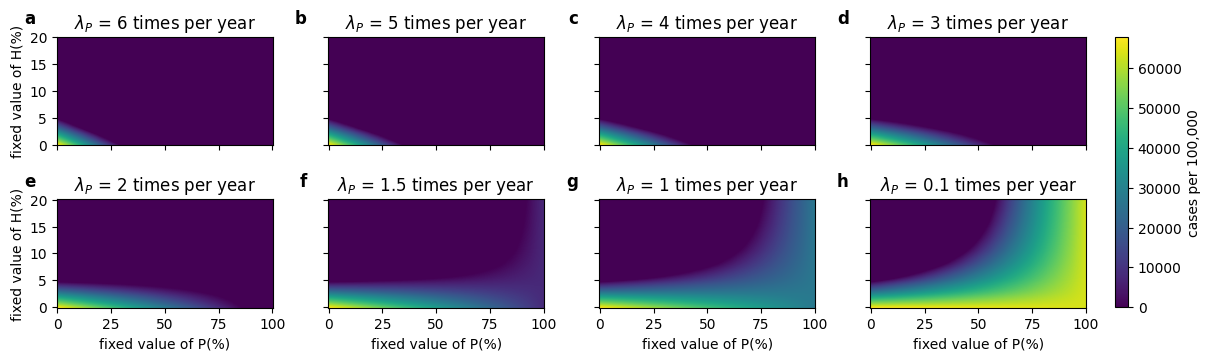

In [4]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
    "0.1 times per year",
]

# Calculate I_star_STI) values for each combination of H, P, and lambda_P
results = {}
for lambda_P in lambda_P_values:
    I_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = calculate_m(H)
            lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
            alpha = calculate_alpha(P, m)
            a = calculate_a(args)
            b = calculate_b(args, lambda_a)
            if calculate_Ro(args, lambda_P, H, P)> 1:
                I_values[i, j] = calculate_I_MATHEMATICA(args, lambda_P, H, P)
                # print(lambda_P, H, P, I_star_STI(H, P, lambda_P))
                # print(I_star_STI(H, P, lambda_P))
    results[lambda_P] = I_values
    print("Min I", np.min(I_values), "Max I", np.max(I_values))
    print("I", I_values)
    # print(I_values[0, 0])

# Determine the global vmin and vmax for log(I_star_STI)
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)

global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)
print(global_vmin, global_vmax)

# Plotting
num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}

fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower")
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )

    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):

    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)


cbar.ax.set_ylabel("cases per 100,000")


plt.show()  

# Susceptible vs $\lambda_P$ (Mathematica)

Min S 0.31685074637323435 Max S 3.3839523580114554
S [[0.31685075 0.32897316 0.34109061 ... 2.62410605 2.63530294 2.64649543]
 [0.34565216 0.35773998 0.36982168 ... 2.62460155 2.63555119 2.64649543]
 [0.3744641  0.38651568 0.39855998 ... 2.62508989 2.63579583 2.64649543]
 ...
 [3.31645227 3.3080543  3.29978919 ... 2.64936135 2.64792473 2.64649543]
 [3.35015772 3.34122665 3.33243942 ... 2.64946225 2.64797499 2.64649543]
 [3.38395236 3.3744773  3.36515757 ... 2.64956127 2.64802432 2.64649543]]
Min S 0.31685074637323435 Max S 3.3839523580114554
S [[0.31685075 0.3269531  0.33705201 ... 2.25212195 2.26157529 2.2710255 ]
 [0.34565216 0.35570146 0.36574635 ... 2.25258352 2.26180649 2.2710255 ]
 [0.3744641  0.38445849 0.39444753 ... 2.25303821 2.26203423 2.2710255 ]
 ...
 [3.31645227 3.30288138 3.28953022 ... 2.2751537  2.27308358 2.2710255 ]
 [3.35015772 3.33600245 3.32208013 ... 2.27524056 2.27312683 2.2710255 ]
 [3.38395236 3.36920132 3.35469696 ... 2.27532566 2.27316921 2.2710255 ]]
Min S 

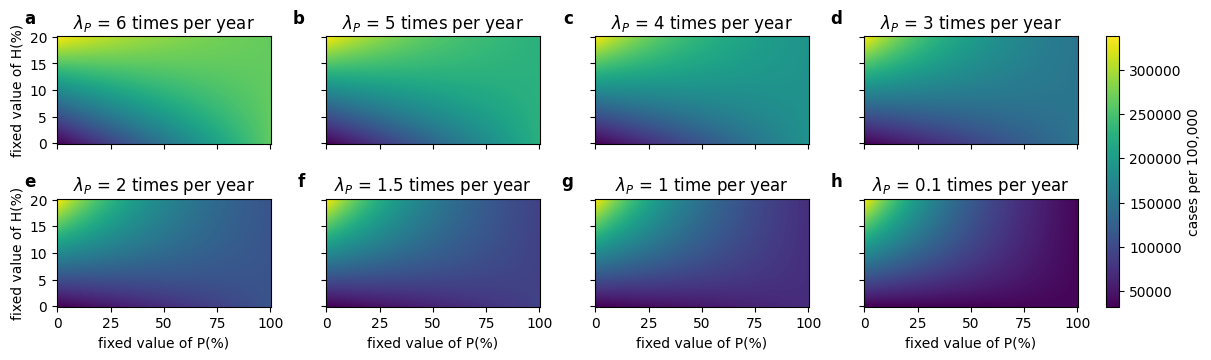

In [98]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 time per year",
    "0.1 times per year",
]

# Calculate S_MATHEMATICA values for each combination of H, P, and lambda_P
results = {}
for lambda_P in lambda_P_values:
    S_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = calculate_m(H)
            lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
            alpha = calculate_alpha(P, m)
            a = calculate_a(args)
            b = calculate_b(args, lambda_a)
            S_values[i, j] = calculate_S_MATHEMATICA(args, lambda_P, H, P)
    results[lambda_P] = S_values
    print("Min S", np.min(S_values), "Max S", np.max(S_values))
    print("S", S_values)

# Determine the global vmin and vmax for log(S_MATHEMATICA)
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)

global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)
print(global_vmin, global_vmax)

# Plotting
num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}

fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower")
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )

    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):

    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)


cbar.ax.set_ylabel("cases per 100,000")


plt.show()


In [4]:
# Parameters
args, y0 = utils.read_params(filename="model_params.txt")


# Mitigation function
def m(H, min_exp=args["min_exp"], max_exp=args["max_exp"], tau_exp=args["tau_exp"]):
    return min_exp + (max_exp - min_exp) * (1 - np.exp(-H / tau_exp))


# Alpha
def alpha(P, H, beta_STI=args["beta_STI"]):
    return beta_STI * (1 - m(H) * (1 - P))

# Heatmap for $\lambda_P$

C:\Users\anton\AppData\Local\Temp\ipykernel_9484\653772608.py:18: RuntimeWarning: invalid value encountered in log
  return np.log(term1-term2)


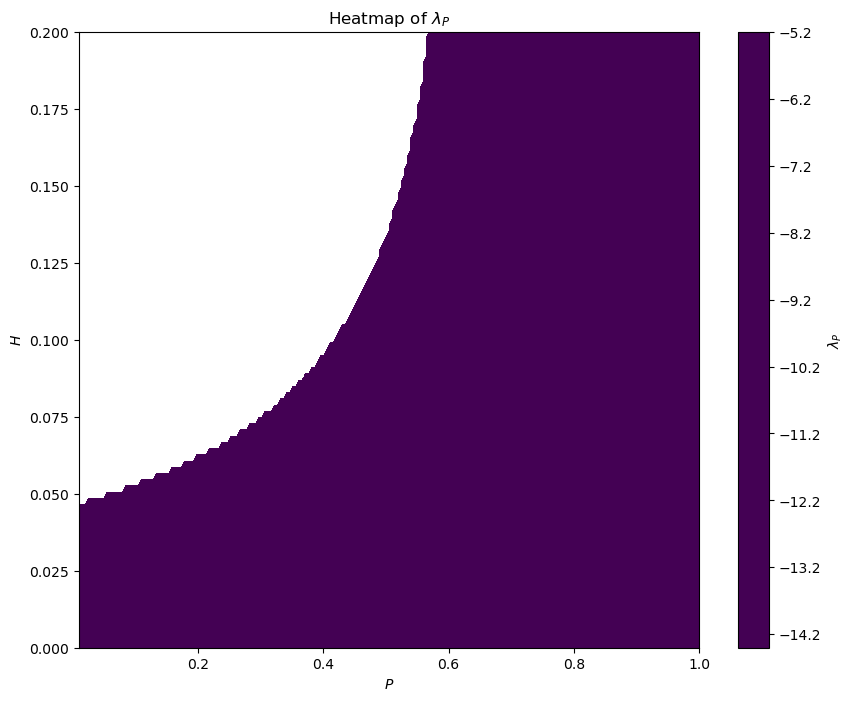

In [145]:
beta_STI_0 = 0.0016 * 5
psi = 0.85
mu = 1.0 / 45.0 / 360.0
gamma = 1.0 / 1.32 / 360.0
C = 50
beta_HIV = 0.6341 / 360.0
min_exp = 0.0
max_exp = 1.0
tau_exp = 0.2
lambda_0 = 1 / 14


# Explicit expression for lambda_P
def lambda_P(P, H):
    term1 = (
        psi
        * (mu + lambda_0)
        / ((mu + lambda_0) / (beta_STI_0 * (1 - m(H) * (1 - P))) - (1 - psi))
    )
    term2 = gamma + C * (1 - m(H)) * beta_HIV * H * (1 - P) + mu
    return np.log(term1 - term2)


# Define the ranges for H and P values
H_values = np.linspace(0, 0.2, 100)
P_values = np.linspace(0.01, 1, 201)  # Avoid P = 0 to prevent division by zero

# Initialize a 2D array to hold lambda_P values
lambda_P_grid = np.zeros((len(H_values), len(P_values)))

# Calculate lambda_P for each combination of H and P
for i, H in enumerate(H_values):
    for j, P in enumerate(P_values):
        lambda_P_grid[i, j] = lambda_P(P, H)

# Plotting
plt.figure(figsize=(10, 8))
plt.contourf(
    P_values, H_values, lambda_P_grid, levels=50, cmap="viridis", vmin=-1, vmax=1
)
plt.colorbar(label="$\lambda_P$")
plt.xlabel("$P$")
plt.ylabel("$H$")
plt.title("Heatmap of $\lambda_P$")
plt.show()

# Asym. Infections (H,P) heatmap for different $\lambda_P$

-0.09763492022512335 -0.14406497287189837
-0.09590239865192735 -0.14419239845666293
-0.09417058577308349 -0.14431982404142749
-0.09243948115383961 -0.14444724962619204
-0.09070908435979916 -0.1445746752109566
-0.08897939495692062 -0.14470210079572116
-0.08725041251151737 -0.1448295263804857
-0.08552213659025719 -0.14495695196525027
-0.08379456676016195 -0.14508437755001485
-0.08206770258860724 -0.1452118031347794
-0.080341543643322 -0.14533922871954397
-0.07861608949238813 -0.1454666543043085
-0.07689133970424021 -0.14559407988907305
-0.0751672938476651 -0.14572150547383764
-0.07344395149180155 -0.14584893105860217
-0.07172131220613984 -0.14597635664336672
-0.06999937556052156 -0.1461037822281313
-0.06827814112513896 -0.1462312078128959
-0.0665576084705349 -0.14635863339766042
-0.06483777716760238 -0.14648605898242498
-0.06311864678758407 -0.14661348456718953
-0.061400216902072154 -0.1467409101519541
-0.05968248708300777 -0.14686833573671865
-0.05796545690268084 -0.1469957613214832
-0.

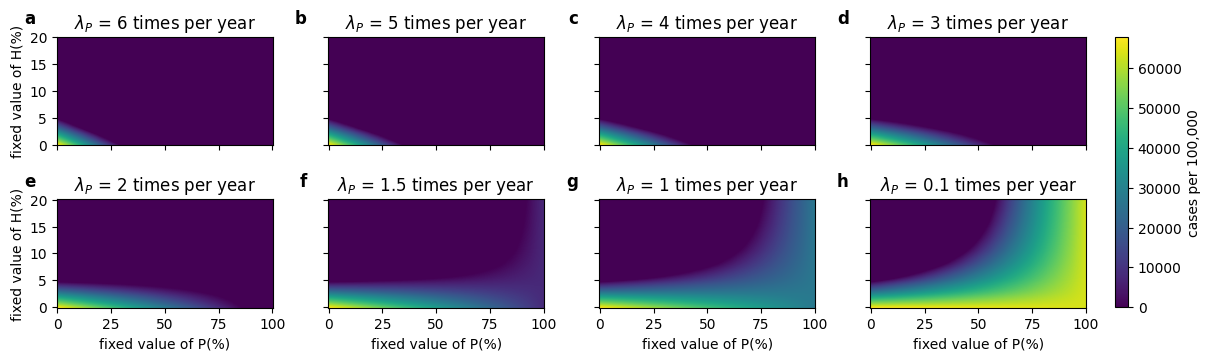

In [5]:
# Define the reproduction number
def Ro(
    H,
    P,
    lambda_P,
    lambda_0=args["lambda_s"],
    beta_HIV=args["beta_HIV"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    C=args["c"],
    psi=args["asymptomatic"],
    tgamma=args["gammaT_STI"],
):
    alpha_val = alpha(P, H)
    term1 = (
        psi
        * alpha_val
        * (lambda_0 + mu)
        / (gamma + lambda_P * P + C * (1 - m(H)) * beta_HIV * H * (1 - P) + mu)
    )
    term2 = (1 - psi) * alpha_val
    return (term1 + term2) / (lambda_0 + mu)


# Define the equation for I^{a,*}_{STI}


def I_star_STI(
    H,
    P,
    lam_P,

    lambda_0=args["lambda_s"],
    beta_HIV=args["beta_HIV"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    C=args["c"],
    psi=args["asymptomatic"],
    tgamma=args["gammaT_STI"],
):
    P_star = P


    H_star = H

    m_star = m(H_star)

    alpha_val = alpha(P_star, H_star)

    # print(P, P_star, H, H_star, m_star, alpha_val)


    common_term = (
        mu

        + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
        + args["lambda_P"] * P_star
    )


    term1 = (mu + tgamma) * (
        (

            (mu + lambda_0)
            / (
                (psi * alpha_val * (mu + lambda_0))
                / (
                    gamma
                    + lam_P * P_star
                    + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
                    + mu
                )

                + (1 - psi) * alpha_val
            )
        )

        - 1
    )


    term2 = (
        -(
            gamma
            + lam_P * P_star
            + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
            + mu
        )

        / psi
    )


    term3 = gamma - tgamma * (
        1
        + (
            (

                gamma
                + lam_P * P_star
                + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
                + mu
            )

            / (lambda_0 + mu)
        )

        * ((1 - psi) / psi)
    )


    numerator = term1
    denominator = term2 + term3

    fraction = numerator / denominator
    print(term1, term2 + term3)

    return fraction



# Define the ranges for H and P values



Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)



# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]



lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2 times per year",

    "1.5 times per year",
    "1 times per year",
    "0.1 times per year",
]



# Calculate log(I_star_STI) values for each combination of H, P, and lambda_P
results = {}

for lambda_P in lambda_P_values:
    I_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            if Ro(H, P, lambda_P) > 1:
                I_values[i, j] = I_star_STI(H, P, lambda_P)
                # print(lambda_P, H, P, I_star_STI(H, P, lambda_P))
                # print(I_star_STI(H, P, lambda_P))
            else:
                I_values[i, j] = 0
    results[lambda_P] = I_values

    print("Min I", np.min(I_values), "Max I", np.max(I_values))

    print("I", I_values)

    # print(I_values[0, 0])



# Determine the global vmin and vmax for log(I_star_STI)


all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)



global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)


print(global_vmin, global_vmax)



# Plotting
num_lambda_P = len(lambda_P_values)


gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}


fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)



nrows, ncols = axes.shape
for idx, lambda_P in enumerate(lambda_P_values):


    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower")


    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")


    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots


    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )


    else:


        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots


    # Set ylabels only on the left most subplots
    if col == 0:


        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )


    else:


        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots


    # Adding subpanel letters, adjust x and y positions as needed


    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )



# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):


    return f"{x * 1e5:.0f}"



# Create a single color bar for the whole figure


cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)



cbar.ax.set_ylabel("cases per 100,000")



plt.show()

# Heatmap (H,P) for bifurcation parameter $R_o$

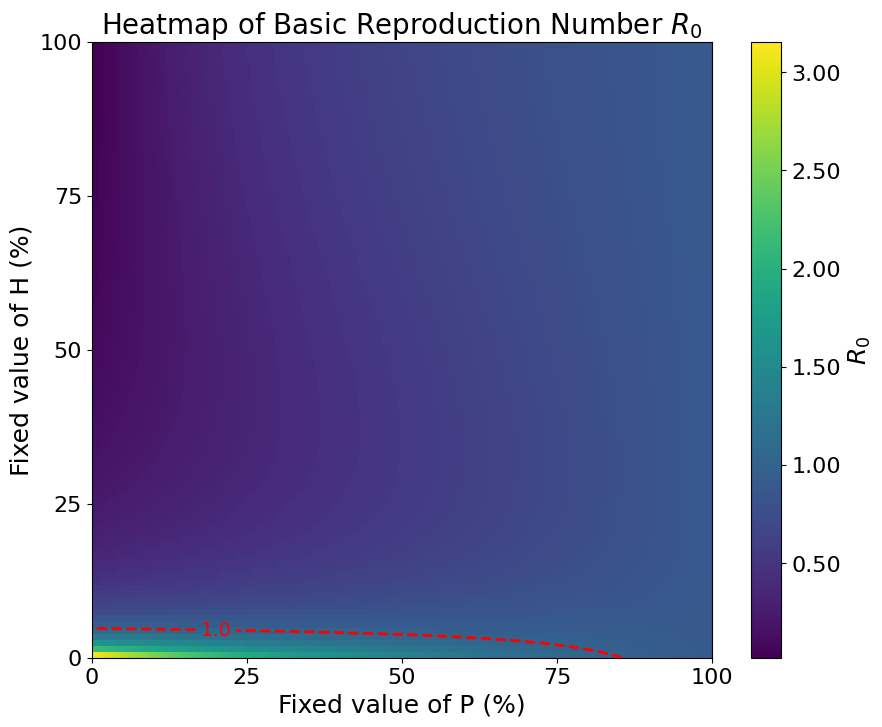

In [9]:

# Define the ranges for H and P values
Hs = np.linspace(0, 1.0, 101)
Ps = np.linspace(0, 1.0, 201)

# Calculate Ro values for each combination of H and P
Ro_values = np.zeros((len(Hs), len(Ps)))
for i, H in enumerate(Hs):
    for j, P in enumerate(Ps):
        Ro_values[i, j] = calculate_Ro(args, args["lambda_P"], H, P)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(
    Ro_values,
    origin="lower",
    aspect="auto",
    extent=[Ps.min(), Ps.max(), Hs.min(), Hs.max()],
    cmap="viridis",
)

# Titles and labels
ax.set_title("Heatmap of Basic Reproduction Number $R_0$", fontsize=20)
ax.set_xlabel("Fixed value of P (%)", fontsize=18)
ax.set_ylabel("Fixed value of H (%)", fontsize=18)

# Setting the ticks and labels with larger font size
ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 5))
ax.set_xticklabels(
    [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 5)], fontsize=16
)
ax.set_yticks(np.linspace(Hs.min(), Hs.max(), 5))
ax.set_yticklabels(
    [f"{int(h * 100)}" for h in np.linspace(Hs.min(), Hs.max(), 5)], fontsize=16
)


# Define a formatter function for the color bar
def formatter(x, pos):
    return f"{x:.2f}"


# Create a color bar with a larger font size
cbar = fig.colorbar(cax, ax=ax, format=FuncFormatter(formatter))
cbar.ax.set_ylabel("$R_0$", fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Add a contour line for R_0 = 1
contour = ax.contour(
    Ps, Hs, Ro_values, levels=[1], colors="red", linewidths=2, linestyles="--"
)

# Add a label to the contour line
ax.clabel(contour, inline=True, fontsize=14, fmt="%.1f", colors="red")

plt.show()

# $R_o$ for an specific set of (H,P)

The value of R_0 for (H, P) = (0.5, 0.5) is: 0.55


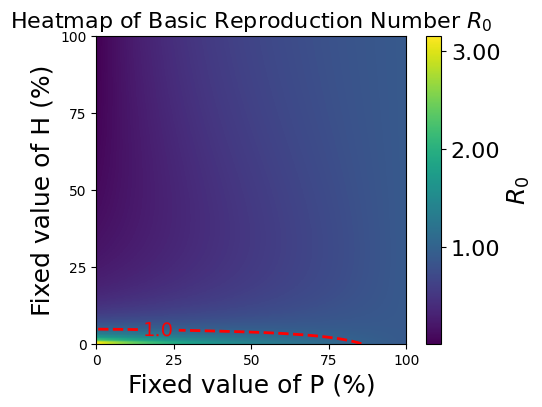

In [10]:
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}

# Define specific (H, P) values
H_value = 0.5
P_value = 0.5

# Calculate R_0 for the specific (H, P) values
R0_value = calculate_Ro(args, args["lambda_P"], H_value, P_value)

# Print the value of R_0
print(f"The value of R_0 for (H, P) = ({H_value}, {P_value}) is: {R0_value:.2f}")

# Plotting
fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.imshow(
    Ro_values,
    origin="lower",
    aspect="auto",
    extent=[Ps.min(), Ps.max(), Hs.min(), Hs.max()],
    cmap="viridis",
)

# Titles and labels
ax.set_title("Heatmap of Basic Reproduction Number $R_0$", fontsize=16)
ax.set_xlabel("Fixed value of P (%)", fontsize=18)
ax.set_ylabel("Fixed value of H (%)", fontsize=18)

# Setting the ticks and labels with larger font size
ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 5))
ax.set_xticklabels(
    [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 5)], fontsize=10
)
ax.set_yticks(np.linspace(Hs.min(), Hs.max(), 5))
ax.set_yticklabels(
    [f"{int(h * 100)}" for h in np.linspace(Hs.min(), Hs.max(), 5)], fontsize=10
)


# Define a formatter function for the color bar
def formatter(x, pos):
    return f"{x:.2f}"


# Create a color bar with a larger font size
cbar = fig.colorbar(cax, ax=ax, format=FuncFormatter(formatter))
cbar.ax.set_ylabel("$R_0$", fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Add a contour line for R_0 = 1
contour = ax.contour(
    Ps, Hs, Ro_values, levels=[1], colors="red", linewidths=2, linestyles="--"
)

# Add a label to the contour line
ax.clabel(contour, inline=True, fontsize=14, fmt="%.1f", colors="red")

plt.show()

# Difference between basic reproduction number $R_o$ in terms of different $\lambda_P$

C:\Users\anton\AppData\Local\Temp\ipykernel_6372\137180058.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


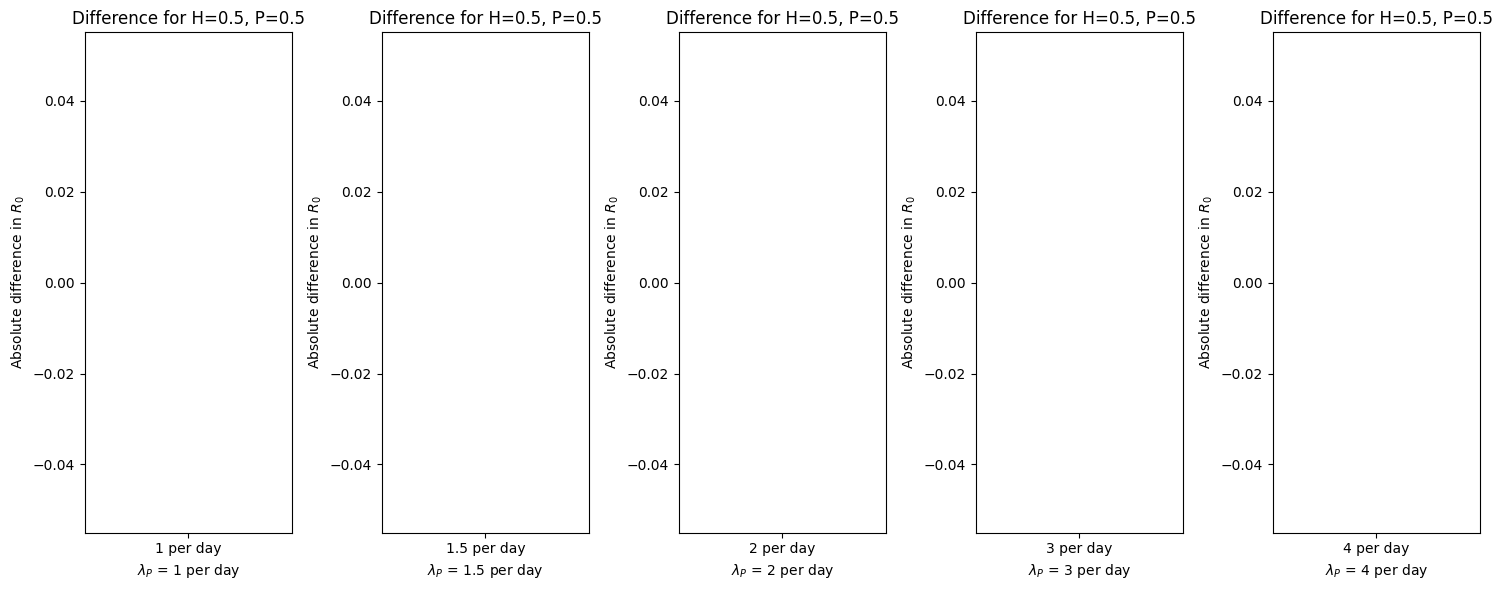

In [12]:
# Define the ranges for H and P values
Hs = np.linspace(0, 1.0, 201)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [1 / 360.0, 1.5 / 360.0, 2 / 360.0, 3 / 360.0, 4 / 360.0]

lambda_P_labels = ["1 per day", "1.5 per day", "2 per day", "3 per day", "4 per day"]

# Calculate Ro values for each combination of H and P for different lambda_P values
Ro_results = {}
for lambda_P in lambda_P_values:
    Ro_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            Ro_values[i, j] = calculate_Ro(args, args["lambda_P"], H, P)
    Ro_results[lambda_P] = Ro_values

# Select a specific (H, P) to calculate differences
specific_H = 0.5
specific_P = 0.5
# Find the indices for specific H and P
H_index = np.argmin(np.abs(Hs - specific_H))
P_index = np.argmin(np.abs(Ps - specific_P))

# Calculate Ro for the specific (H, P) and compute differences
Ro_specific = {
    lambda_P: Ro_results[lambda_P][H_index, P_index] for lambda_P in lambda_P_values
}
Ro_diff = abs(
    np.array([Ro_specific[lambda_P] for lambda_P in lambda_P_values])
    - Ro_specific[lambda_P_values[0]]
)

# Plotting
fig, axes = plt.subplots(
    1, len(lambda_P_values), figsize=(15, 6), constrained_layout=True
)

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes[idx]
    diff = Ro_diff[idx]
    ax.bar(lambda_P_labels[idx], diff, color="b")
    ax.set_title(f"Difference for H={specific_H}, P={specific_P}")
    ax.set_xlabel(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_ylabel("Absolute difference in $R_0$")

plt.tight_layout()
plt.show()

# Sym. Infections (H,P) heatmap for different $\lambda_P$

0.0 0.004143487513629801


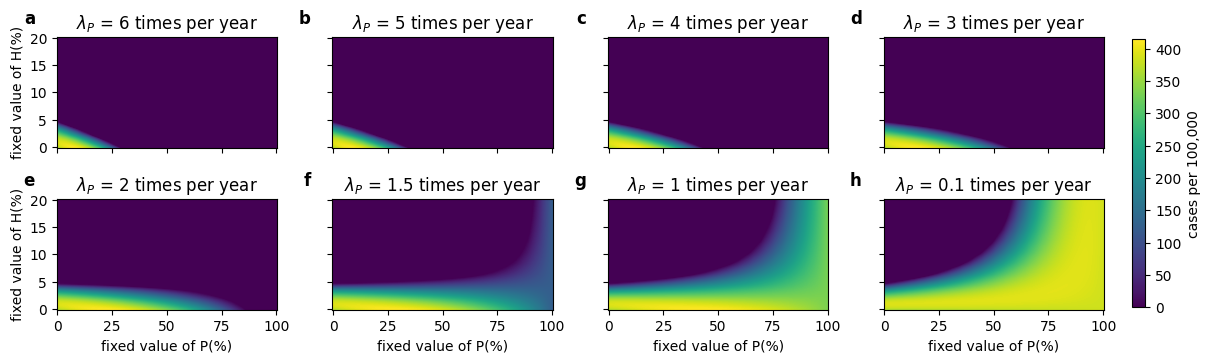

In [5]:

# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
    "0.1 times per year",
]


# Store the results for each lambda_P
results = {}

# Calculate SirsComparison for each combination of lambda_P, H, P
for lambda_P in lambda_P_values:
    result = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            if (calculateI_Symtomatic_Math(args, lambda_P, H, P))>0:
                result[i, j] = calculateI_Symtomatic_Math(args, lambda_P, H, P)
    results[lambda_P] = result  

# Determine the global vmin and vmax
all_infections = np.concatenate([results[lambda_P].flatten() for lambda_P in lambda_P_values])
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)
print(global_vmin, global_vmax)

# Plotting
num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}

fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax, cmap="viridis")
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )

    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)

cbar.ax.set_ylabel("cases per 100,000")
plt.show()

# Contour for $R_o=1$

-0.9125528604921229


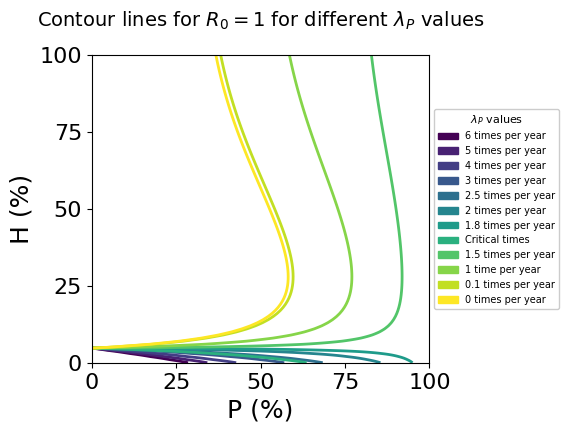

In [18]:
from matplotlib.patches import Patch

def bifurcationP(
    betaSTI=args["beta_STI"],
    lambda_0=args["lambda_0"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    psi=args["asymptomatic"],
):
    lambdap = (
        psi * (lambda_0 + mu) / ((lambda_0 + mu) / betaSTI - (1 - psi)) - mu - gamma
    )
    return lambdap


bifur = bifurcationP()
print(bifur * 360)
# Define the ranges for H and P values
Hs = np.linspace(0, 1.0, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360.0,
    5 / 360.0,
    4 / 360.0,
    3 / 360.0,
    2.5 / 360.0,
    2 / 360.0,
    1.8 / 360,
    bifur+0.01,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360,
    0,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.8 times per year",
    "Critical times",
    "1.5 times per year",
    "1 time per year",
    "0.1 times per year",
    "0 times per year",
]

colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_P_values)))

# Plotting the contour lines for R_0 = 1 for different lambda_P values
fig, ax = plt.subplots(figsize=(5, 4))

for lambda_P, color in zip(lambda_P_values, colors):
    # Calculate Ro values for each combination of H and P
    Ro_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            Ro_values[i, j] = calculate_Ro(args, lambda_P, H, P)

    # Add a contour line for R_0 = 1
    ax.contour(
        Ps, Hs, Ro_values, levels=[1], linewidths=2, linestyles="-", colors=[color]
    )

# Titles and labels
ax.set_title(
    "Contour lines for $R_0 = 1$ for different $\lambda_P$ values", fontsize=14, pad=20
)
ax.set_xlabel("P (%)", fontsize=18)
ax.set_ylabel("H (%)", fontsize=18)

# Setting the ticks and labels with larger font size
ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 5))
ax.set_xticklabels(
    [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 5)], fontsize=16
)
ax.set_yticks(np.linspace(Hs.min(), Hs.max(), 5))
ax.set_yticklabels(
    [f"{int(h * 100)}" for h in np.linspace(Hs.min(), Hs.max(), 5)], fontsize=16
)

# Adding a custom legend outside the plot
legend_patches = [
    Patch(color=color, label=label) for color, label in zip(colors, lambda_P_labels)
]
legend = ax.legend(
    handles=legend_patches,
    title="$\lambda_P$ values",
    fontsize=7,
    title_fontsize=8,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(1)

# ax.set_xlim(0.7, 1.0)  # Adjust x-axis limits
# ax.set_ylim(0, 0.3)    # Adjust y-axis limits

# Adjusting the layout to make room for the legend
plt.subplots_adjust(right=0.8)

plt.show()

# "Continuos" lambda_P

C:\Users\anton\AppData\Local\Temp\ipykernel_6372\1821867000.py:26: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(
C:\Users\anton\AppData\Local\Temp\ipykernel_6372\1821867000.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


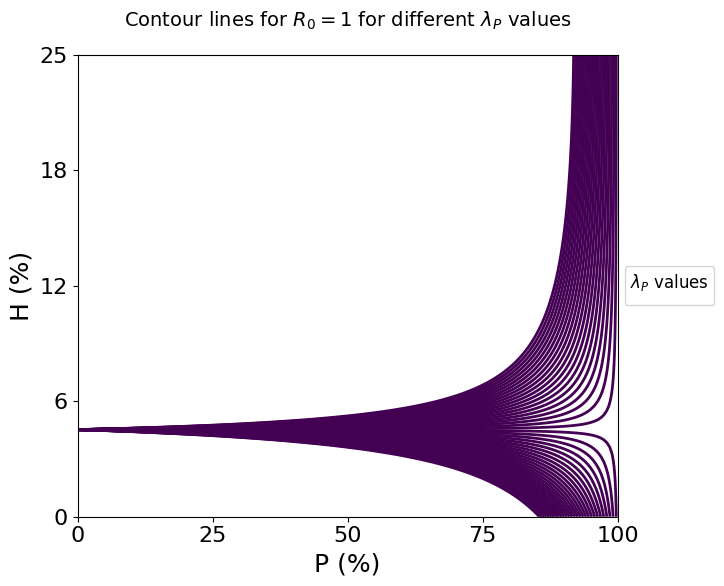

In [14]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.25, 101)
Ps = np.linspace(0, 1.0, 201)

# Define the continuous range for lambda_P
lambda_P_min = 1.5 / 360.0
lambda_P_max = 2 / 360.0
lambda_P_values = np.linspace(
    lambda_P_min, lambda_P_max, 50
)  # Adjust the number of values for smoothness

# Plotting the contour lines for R_0 = 1 for different lambda_P values
fig, ax = plt.subplots(figsize=(8, 6))

# Generate a grid of H and P values
H_grid, P_grid = np.meshgrid(Hs, Ps)

# Calculate Ro values for each lambda_P
for lambda_P in lambda_P_values:
    Ro_values = np.zeros_like(H_grid)
    for i in range(H_grid.shape[0]):
        for j in range(H_grid.shape[1]):
            Ro_values[i, j] = calculate_Ro(args, lambda_P, H_grid[i, j], P_grid[i, j])

    # Plot contour lines for R_0 = 1
    ax.contour(
        P_grid,
        H_grid,
        Ro_values,
        levels=[1],
        linewidths=2,
        linestyles="-",
        label=f"{lambda_P*360:.1f} times per year",
    )

# Titles and labels
ax.set_title(
    "Contour lines for $R_0 = 1$ for different $\lambda_P$ values", fontsize=14, pad=20
)
ax.set_xlabel("P (%)", fontsize=18)
ax.set_ylabel("H (%)", fontsize=18)

# Setting the ticks and labels with larger font size
ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 5))
ax.set_xticklabels(
    [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 5)], fontsize=16
)
ax.set_yticks(np.linspace(Hs.min(), Hs.max(), 5))
ax.set_yticklabels(
    [f"{int(h * 100)}" for h in np.linspace(Hs.min(), Hs.max(), 5)], fontsize=16
)

# Adding a legend
ax.legend(
    title="$\\lambda_P$ values",
    fontsize=10,
    title_fontsize=12,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

# Adjusting the layout to make room for the legend
plt.subplots_adjust(right=0.8)

plt.show()

# For nice plots


## Asymptomatic

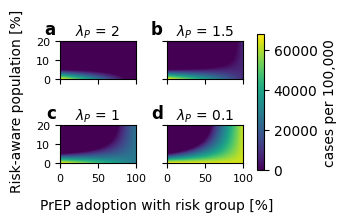

In [50]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define the specific values for lambda_P that you want to represent
lambda_P_values = [
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "2",
    "1.5",
    "1",
    "0.1",
]

# Calculate I_star_STI values for each combination of H, P, and lambda_P
results = {}
for lambda_P in lambda_P_values:
    I_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = calculate_m(H)
            lambda_a = calculate_lambda_a(args, lambda_P, m, P, H)
            alpha = calculate_alpha(P, m)
            a = calculate_a(args)
            b = calculate_b(args, lambda_a)
            if calculate_Ro(args, lambda_P, H, P) > 1:
                I_values[i, j] = calculate_I_MATHEMATICA(args, lambda_P, H, P)
    results[lambda_P] = I_values

# Determine the global vmin and vmax for log(I_star_STI)
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)

global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Adjusted Plotting
fig, axes = plt.subplots(
    2, 2,  # 2x2 grid for 4 subplots
    figsize=(3, 2),
    constrained_layout=False
)

# Reduce spacing between plots
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# Plot each subplot
for idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {label}", fontsize=10, pad=2)

    # Set xlabels only on the bottom most subplots
    if idx // 2 == 1:
        ax.set_xlabel("", fontsize=8)
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[100] * 100),
                int(Ps[200] * 100),
            ],
            fontsize=8
        )
    else:
        # Show the middle tick without labels for top subplots
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([])

    # Set ylabels only on the left most subplots
    if idx % 2 == 0:
        ax.set_ylabel("", fontsize=8)
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[50] * 100),
                int(Hs[100] * 100),
            ],
            fontsize=8
        )
    else:
        ax.set_yticklabels([])

    # Adding subpanel letters aligned with λ_P titles
    ax.text(
        -0.05, 1.05, chr(97 + idx),  # 'chr(97)' gives 'a', 'chr(98)' gives 'b', etc.
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="bottom",
        ha="right",
    )

# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.06,  # Increased padding to move color bar to the right
)

# Shared axis labels
fig.text(0.45, -0.04, "PrEP adoption with risk group [%]", ha='center', fontsize=10)
fig.text(-0.04, 0.5, "Risk-aware population [%]", va='center', rotation='vertical', fontsize=10)

cbar.ax.set_ylabel("cases per 100,000")

plt.show()





## Symtomatic

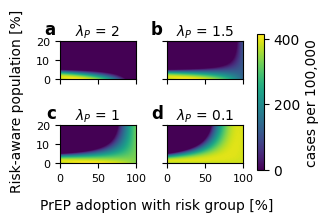

In [51]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define the specific values for lambda_P that you want to represent
lambda_P_values = [
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "2",
    "1.5",
    "1",
    "0.1",
]

results = {}
for lambda_P in lambda_P_values:
    result = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            if (calculateI_Symtomatic_Math(args, lambda_P, H, P))>0:
                result[i, j] = calculateI_Symtomatic_Math(args, lambda_P, H, P)
    results[lambda_P] = result  

# Determine the global vmin and vmax
all_infections = np.concatenate([results[lambda_P].flatten() for lambda_P in lambda_P_values])
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Adjusted Plotting
fig, axes = plt.subplots(
    2, 2,  # 2x2 grid for 4 subplots
    figsize=(3, 2),
    constrained_layout=False
)

# Reduce spacing between plots
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# Plot each subplot
for idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {label}", fontsize=10, pad=2)

    # Set xlabels only on the bottom most subplots
    if idx // 2 == 1:
        ax.set_xlabel("", fontsize=8)
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[100] * 100),
                int(Ps[200] * 100),
            ],
            fontsize=8
        )
    else:
        # Show the middle tick without labels for top subplots
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([])

    # Set ylabels only on the left most subplots
    if idx % 2 == 0:
        ax.set_ylabel("", fontsize=8)
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[50] * 100),
                int(Hs[100] * 100),
            ],
            fontsize=8
        )
    else:
        ax.set_yticklabels([])

    # Adding subpanel letters aligned with λ_P titles
    ax.text(
        -0.05, 1.05, chr(97 + idx),  # 'chr(97)' gives 'a', 'chr(98)' gives 'b', etc.
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="bottom",
        ha="right",
    )

# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.06,  # Increased padding to move color bar to the right
)

# Shared axis labels
fig.text(0.45, -0.04, "PrEP adoption with risk group [%]", ha='center', fontsize=10)
fig.text(-0.04, 0.5, "Risk-aware population [%]", va='center', rotation='vertical', fontsize=10)

cbar.ax.set_ylabel("cases per 100,000")

plt.show()


# Both symptomatic and asymptomatic

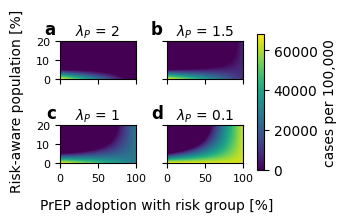

In [52]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define the specific values for lambda_P that you want to represent
lambda_P_values = [
    2 / 360.0,
    1.5 / 360.0,
    1 / 360.0,
    0.1 / 360.0,
]

lambda_P_labels = [
    "2",
    "1.5",
    "1",
    "0.1",
]

results = {}
for lambda_P in lambda_P_values:
    result = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            if (calculateI_Symtomatic_Math(args, lambda_P, H, P))>0:
                result[i, j] = (calculate_I_MATHEMATICA(args, lambda_P, H, P) + calculateI_Symtomatic_Math(args, lambda_P, H, P))
    results[lambda_P] = result  

# Determine the global vmin and vmax
all_infections = np.concatenate([results[lambda_P].flatten() for lambda_P in lambda_P_values])
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Adjusted Plotting
fig, axes = plt.subplots(
    2, 2,  # 2x2 grid for 4 subplots
    figsize=(3, 2),
    constrained_layout=False
)

# Reduce spacing between plots
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# Plot each subplot
for idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {label}", fontsize=10, pad=2)

    # Set xlabels only on the bottom most subplots
    if idx // 2 == 1:
        ax.set_xlabel("", fontsize=8)
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[100] * 100),
                int(Ps[200] * 100),
            ],
            fontsize=8
        )
    else:
        # Show the middle tick without labels for top subplots
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([])

    # Set ylabels only on the left most subplots
    if idx % 2 == 0:
        ax.set_ylabel("", fontsize=8)
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[50] * 100),
                int(Hs[100] * 100),
            ],
            fontsize=8
        )
    else:
        ax.set_yticklabels([])

    # Adding subpanel letters aligned with λ_P titles
    ax.text(
        -0.05, 1.05, chr(97 + idx),  # 'chr(97)' gives 'a', 'chr(98)' gives 'b', etc.
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="bottom",
        ha="right",
    )

# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.06,  # Increased padding to move color bar to the right
)

# Shared axis labels
fig.text(0.45, -0.04, "PrEP adoption with risk group [%]", ha='center', fontsize=10)
fig.text(-0.04, 0.5, "Risk-aware population [%]", va='center', rotation='vertical', fontsize=10)

cbar.ax.set_ylabel("cases per 100,000")

plt.show()